# Journal Profiling Part 4: Institutions

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract information about the authors affiliations data linked to [publications](https://docs.dimensions.ai/dsl/datasource-publications.html) of a specific journal.

This tutorial is the fourth of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.

In this notebook we are going to 

* Load the publications data extracted in part 1
* Focus on institutions linked to a journal: measure how often do they appear, how many affiliated authors they have etc..
* Build some simple visualizations in order to have a quick overview of the results 

## Prerequisites: Installing the Dimensions Library and Logging in

In [1]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import os
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

DimCli v0.6.8.1 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Institutions Contributing to a Journal

From our original publications dataset, we now want to look at institutions i.e. 

* getting the full list of institutions (also ones without a GRID, for subsequent analysis) linked to the journal
* publications count 
* authors count 

Let's reload the affiliations data from Part-1 of this tutorial series.

**NOTE** If you are using Google Colab or don't have the data available, just grab it [here](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data) and make sure they're saved in a folder called `journal-profile-data` where this notebook is. 


In [2]:
affiliations = pd.read_csv(FOLDER_NAME+"/1_publications_affiliations.csv")
affiliations.head(10)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1127548497,NaN,Isidro,Cortés-Ciriano
1,NaN,"Ludwig Center at Harvard, Boston, MA, USA",NaN,NaN,NaN,NaN,NaN,NaN,pub.1127548497,NaN,Isidro,Cortés-Ciriano
2,grid.5335.0,University of Cambridge,Cambridge,2653941.0,United Kingdom,GB,NaN,NaN,pub.1127548497,NaN,Isidro,Cortés-Ciriano
3,grid.225360.0,European Bioinformatics Institute,Cambridge,2653941.0,United Kingdom,GB,NaN,NaN,pub.1127548497,NaN,Isidro,Cortés-Ciriano
4,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1127548497,NaN,Jake June-Koo,Lee
5,NaN,"Ludwig Center at Harvard, Boston, MA, USA",NaN,NaN,NaN,NaN,NaN,NaN,pub.1127548497,NaN,Jake June-Koo,Lee
6,grid.11135.37,Peking University,Beijing,1816670.0,China,CN,NaN,NaN,pub.1127548497,NaN,Ruibin,Xi
7,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1127548497,NaN,Dhawal,Jain
8,grid.38142.3c,Harvard University,Cambridge,4931972.0,United States,US,Massachusetts,US-MA,pub.1127548497,NaN,Youngsook L.,Jung
9,NaN,"Ben May Department for Cancer Research, Univer...",NaN,NaN,NaN,NaN,NaN,NaN,pub.1127548497,NaN,Lixing,Yang


## Basic stats about affiliations

* count how many affiliations statements in total
* count how many affiliations have a GRID ID
* count how many unique GRID IDs we have in total

In [3]:
#
# segment the affiliations dataset
affiliations = affiliations.fillna('') 
affiliations_with_grid = affiliations.query("aff_id != ''")
affiliations_without_grid = affiliations.query("aff_id == ''")
#
# save
save(affiliations_without_grid, "4_institutions_without_grid.csv")

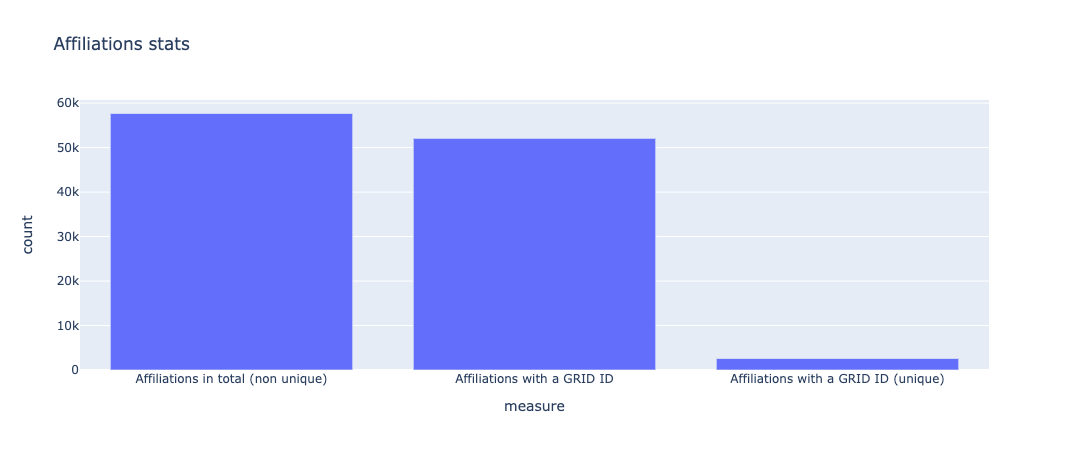

In [4]:
# build a summary barchart

df = pd.DataFrame({
    'measure' : ['Affiliations in total (non unique)', 'Affiliations with a GRID ID', 'Affiliations with a GRID ID (unique)'],
    'count' : [len(affiliations), len(affiliations_with_grid), affiliations_with_grid['aff_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Affiliations stats")

## Enriching the unique affiliations (GRIDs list) with pubs count and authors count

We want a table with the following columns 

* grid ID
* city
* country
* country code
* name
* tot_pubs
* tot_affiliations

NOTE: tot_affiliations is a list of 'authorships' (ie authors in the context of each publication). 

For out analysis we can start from the `gridaffiliations` dataframe. 

In [5]:
affiliations_with_grid.head(5)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1127548497,,Isidro,Cortés-Ciriano
2,grid.5335.0,University of Cambridge,Cambridge,2.65394e+06,United Kingdom,GB,,,pub.1127548497,,Isidro,Cortés-Ciriano
3,grid.225360.0,European Bioinformatics Institute,Cambridge,2.65394e+06,United Kingdom,GB,,,pub.1127548497,,Isidro,Cortés-Ciriano
4,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1127548497,,Jake June-Koo,Lee
6,grid.11135.37,Peking University,Beijing,1.81667e+06,China,CN,,,pub.1127548497,,Ruibin,Xi


In [6]:
gridaffiliations = affiliations_with_grid.copy()
#
# group by GRIDID and add new column with affiliations count
gridaffiliations["tot_affiliations"] = gridaffiliations.groupby('aff_id')['aff_id'].transform('count')
#
# add new column with publications count, for each GRID
gridaffiliations["tot_pubs"] = gridaffiliations.groupby(['aff_id'])['pub_id'].transform('nunique')
# 
# remove unnecessary columns
gridaffiliations = gridaffiliations.drop(['aff_city_id', 'pub_id', 'researcher_id', 'first_name', 'last_name'], axis=1).reset_index(drop=True)
#
# remove duplicate rows
gridaffiliations.drop_duplicates(inplace=True)
#
# update columns order
gridaffiliations = gridaffiliations[[ 'aff_id', 'aff_name','aff_city', 
                                     'aff_country', 'aff_country_code',  'aff_state',
                                     'aff_state_code', 'tot_affiliations',  'tot_pubs']]
#
# sort
gridaffiliations = gridaffiliations.sort_values(['tot_affiliations', 'tot_pubs'], ascending=False)
#
#
# That's it! Let's see the result
gridaffiliations.head()

,aff_id,aff_name,aff_city,aff_country,aff_country_code,aff_state,aff_state_code,tot_affiliations,tot_pubs
387,grid.66859.34,Broad Institute,Cambridge,United States,US,Massachusetts,US-MA,1386,225
0,grid.38142.3c,Harvard University,Cambridge,United States,US,Massachusetts,US-MA,1204,265
1,grid.5335.0,University of Cambridge,Cambridge,United Kingdom,GB,,,935,158
423,grid.10306.34,Wellcome Sanger Institute,Cambridge,United Kingdom,GB,,,705,142
551,grid.32224.35,Massachusetts General Hospital,Boston,United States,US,Massachusetts,US-MA,698,140


In [7]:
# save the data
save(gridaffiliations, "4_institutions_with_grid_with_metrics.csv")

## Couple of Dataviz

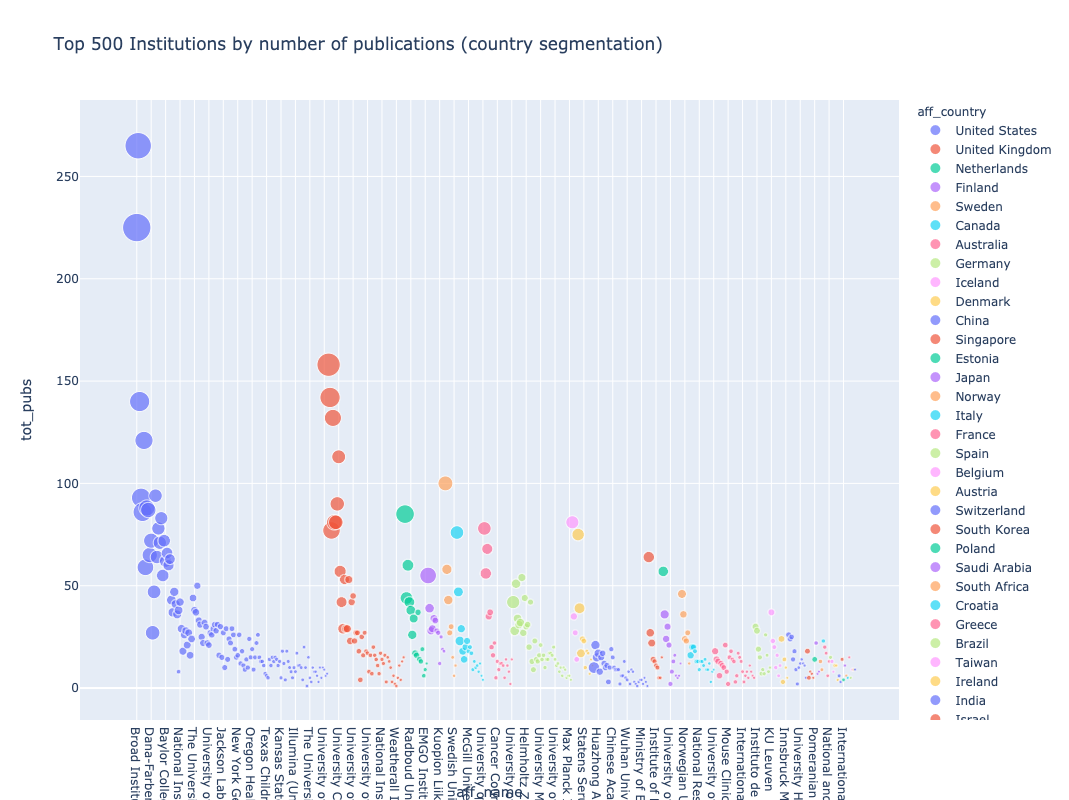

In [8]:
treshold = 500

px.scatter(gridaffiliations[:treshold], 
           x="aff_name", y="tot_pubs", 
           color="aff_country", 
           size='tot_affiliations',
           hover_name="aff_name", 
           height=800,
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions by number of publications (country segmentation)")

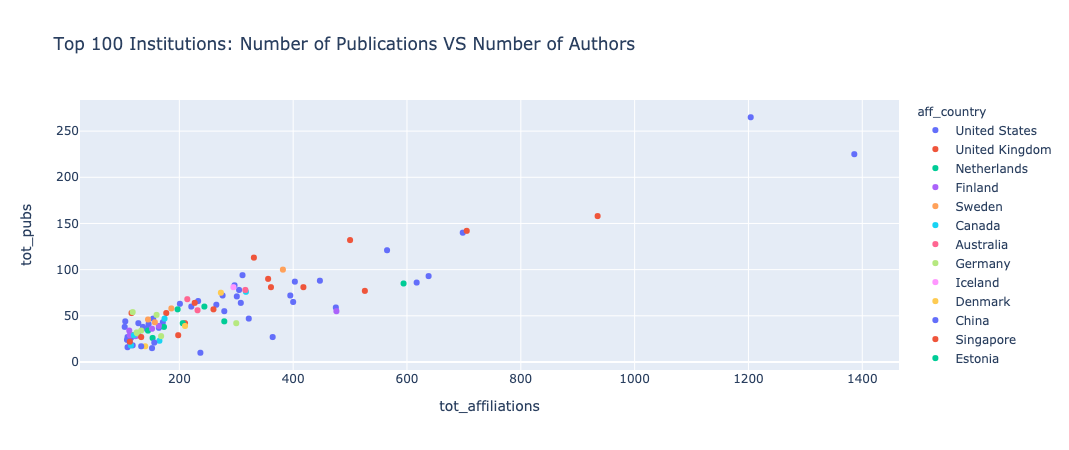

In [9]:
treshold = 100

px.scatter(gridaffiliations[:treshold], 
           x="tot_affiliations", y="tot_pubs", 
           color="aff_country",
           hover_name="aff_name", 
           hover_data=['aff_id', 'aff_name', 'aff_city', 'aff_country', 'tot_affiliations', 'tot_pubs'], 
           title=f"Top {treshold} Institutions: Number of Publications VS Number of Authors")